## Spectral Analysis of Snow Depth in MA

## Loading libdaries and data
### Load the required libraries

In [1]:
#cs.stop()

NameError: name 'sc' is not defined

In [2]:
%%time
%run lib/startup.py

10.47.192.17
dict_items([('spark.app.name', 'spark on MLBP'), ('spark.master', 'spark://spark-master:7077'), ('spark.blockmanager.port', '50002'), ('spark.driver.bindAddress', '10.47.192.17'), ('spark.driver.host', '10.47.192.17'), ('spark.driver.port', '50500'), ('spark.cores.max', '4'), ('spark.executor.memory', '512m'), ('spark.authenticate', 'False')])
sparkContext= <SparkContext master=spark://spark-master:7077 appName=spark on MLBP>

    pandas as    pd 	version=1.1.5 	required version>=0.19.2

     numpy as    np 	version=1.19.5 	required version>=1.12.0

   sklearn as    sk 	version=0.24.2 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.4.4 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.6.3 	required version>=6.0.0

version of ipwidgets= 7.6.3
measurements is a Dataframe with 12720632 records
stations is a Dataframe with 119503 records
CPU times: user 1.68 s, sys: 1.58 s, total: 3.26 s
Wall time: 13.3 s


In [ ]:
%pylab inline

In [3]:
%%time
weather=measurements.join(stations,on='station')
weather.show(3)

sqlContext.registerDataFrameAsTable(weather,'weather')

+-----------+-----------+----+--------------------+--------+---------+---------+------------+-------------------+-----+-------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|  dist2coast|               name|state|country|
+-----------+-----------+----+--------------------+--------+---------+---------+------------+-------------------+-----+-------+
|AG000060390|       TAVG|2022|[79 00 6C 00 66 0...| 36.7167|     3.25|     24.0|   8.0234375| ALGER-DAR EL BEIDA|     |Algeria|
|AGE00147716|       TAVG|2022|[85 00 83 00 7C 0...|    35.1|    -1.85|     83.0|0.5224609375|NEMOURS (GHAZAOUET)|     |Algeria|
|AGM00060360|       TMIN|2022|[5A 00 19 FC 4B 0...|  36.822|    7.809|      4.9|  3.16015625|             ANNABA|     |Algeria|
+-----------+-----------+----+--------------------+--------+---------+---------+------------+-------------------+-----+-------+
only showing top 3 rows

CPU times: user 4.89 ms, sys: 2.93 ms, total: 7.82 ms
Wall time: 2.66 s


### Read Statistics File

In [4]:
state='MA'

ms=['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']
# ms=['TMAX', 'TMIN', 'TOBS']
cms='or\n'.join(['Measurement="%s" '%(m) for m in ms])

##  read all data for state
Query="""
SELECT *
FROM weather
WHERE state="%s" and 
(%s)
"""%(state,cms)
print(Query)

### read or compute statistics information for state.

#%%time
import os.path
from lib.computeStatistics import computeStatistics
from pickle import dump,load

pkl_filename=parquet_root+'weather-statistics/'+state+'-'+','.join(ms)+'.pkl'
print(pkl_filename)
!ls $pkl_filename



SELECT *
FROM weather
WHERE state="MA" and 
(Measurement="TMAX" or
Measurement="SNOW" or
Measurement="SNWD" or
Measurement="TMIN" or
Measurement="PRCP" or
Measurement="TOBS" )

/datasets/cs255-sp22-a00-public/weather-statistics/MA-TMAX,SNOW,SNWD,TMIN,PRCP,TOBS.pkl
/datasets/cs255-sp22-a00-public/weather-statistics/MA-TMAX,SNOW,SNWD,TMIN,PRCP,TOBS.pkl


In [5]:
if os.path.isfile(pkl_filename):   
    print('precomputed statistics file exists')
    with open(pkl_filename,'br') as pkl_file:
        stat=load(pkl_file)
else:
    print('computing statistics')
    stat=computeStatistics(sqlContext,df,measurements=ms)
    with open(pkl_filename,'bw') as pkl_file:
        dump(stat,pkl_file)
STAT=stat
stat.keys()

precomputed statistics file exists


dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])

## Computing decomposition for each row, and add columns for coefficients and residuals

Residuals are the remainder left after successive approximations:  
1) Original vector = $\vec{v}$

2) $\vec{r}_0=\vec{v}-\vec{\mu}$

3) $\vec{r}_1=\vec{r}_0-(\vec{v}\cdot \vec{u}_1) \vec{u}_1$

4) $\vec{r}_2=\vec{r}_1-(\vec{v}\cdot \vec{u}_2) \vec{u}_2$

5) $\vec{r}_3=\vec{r}_0-(\vec{v}\cdot \vec{u}_3) \vec{u}_3$  
6) ......

For each reidual $\vec{r}_i$ we compute it's square norm, which we will refer to as **residual norm** :
$$\|\vec{r}_i\|_2^2 = \sum_{j=1}^n (r_{i,j})^2$$  
The smaller tha norm, the better the approximation.

#### A few things we know from linear algebra:

1) The zero'th residual norm is the square distance of $\vec{v}$ from the mean $\vec{\mu}$

2) The $k$'th residual norm is the minimal square between $\vec{v}$ and a point that can be exspressed as
$$ \vec{w}_k = \vec{\mu} + \sum_{i=1}^k c_i \vec{u}_i$$
Where $c_1,\ldots,c_k$ are arbitrary real numbers. We call $\vec{w}_k$ the $k$'th approximation or reconstruction of $\vec{v}$.

3) The residual norms are non-increasing.  
4) The residual vector $\vec{r}_n$ is the zero vector. In other words, $\vec{w}_n = \vec{v}$.

`decompose_dataframe` axtracts the series from the row, computes the `k` to decomposition coefficients and 
the square norm of the residuals and constructs a new row that is reassembled into a new dataframe.  

For more details, use `%load lib/decomposer.py`

### Lets do some decompositions!

In [63]:
m='SNWD'
state='MA'

#get mean and eigenvectors for measurement m
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']
EigVec.shape

(366, 366)

In [64]:
%%time
Query="""
select *
from weather
WHERE state='%s' and measurement='%s'
"""%(state,m)
df=sqlContext.sql(Query)
print('number of records=',df.count())
df.show(3)

number of records= 8750
+-----------+-----------+----+--------------------+--------+---------+---------+-------------+-----------------+-----+-------------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|   dist2coast|             name|state|      country|
+-----------+-----------+----+--------------------+--------+---------+---------+-------------+-----------------+-----+-------------+
|US1MABA0018|       SNWD|2022|[00 00 00 00 19 F...| 41.5818| -70.5257|      9.8|0.94091796875|  WAQUOIT 0.6 SSW|   MA|United States|
|US1MABA0060|       SNWD|2022|[00 00 00 00 00 0...| 41.6581| -70.3077|     14.0|  2.849609375|  HYANNIS 0.7 WNW|   MA|United States|
|US1MAES0004|       SNWD|2022|[00 00 00 00 00 0...| 42.7471| -71.0426|      8.2|          NaN|GROVELAND 0.5 WSW|   MA|United States|
+-----------+-----------+----+--------------------+--------+---------+---------+-------------+-----------------+-----+-------------+
only showing top 3 rows

CPU times: user 2.26

In [65]:
EigVec.shape

(366, 366)

In [66]:
%%time
k=5
df2=decompose_dataframe(sqlContext,df,EigVec[:,:k],Mean).cache() # Make it possible to generate only first k coefficients.

CPU times: user 32.1 ms, sys: 3.17 ms, total: 35.3 ms
Wall time: 484 ms


In [67]:
%%time
print(df2.count())

8750
CPU times: user 8.01 ms, sys: 1.17 ms, total: 9.18 ms
Wall time: 11 s


### Join decomposition information with station information

In [72]:
col=df2.columns

Dcol={}
Dcol['station,year,measurement info']=col[:4]+col[9:14]+[col[21]]
Dcol['coeff']=col[4:9]
Dcol['residuals']=[col[22]]+[col[20]]+col[15:20]
for key in Dcol:
    print('==',key,'==')
    print(','.join(Dcol[key]))

== station,year,measurement info ==
Measurement,Station,Values,Year,country,dist2coast,elevation,latitude,longitude,state
== coeff ==
coeff_1,coeff_2,coeff_3,coeff_4,coeff_5
== residuals ==
total_var,res_mean,res_1,res_2,res_3,res_4,res_5


### Removing years with little snow
In some locations and in some year, there is almost no snow accumulation. We want to treat these separately.

To do so we compare the error of using the average to the error of using a zero vector. We keep only those yearXstation where the mean is a better approximation than the zero Vector

In [73]:
%%time
#filter out vectors for which the mean is a worse approximation than zero.
print('all Rows',df2.count())
df3=df2.filter(df2.res_mean<1)
print('Rows where mean is better approx than zero',df3.count())

all Rows 8750
Rows where mean is better approx than zero 4172
CPU times: user 12.7 ms, sys: 4.39 ms, total: 17.1 ms
Wall time: 435 ms


## Plot mean and top eigenvectors

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

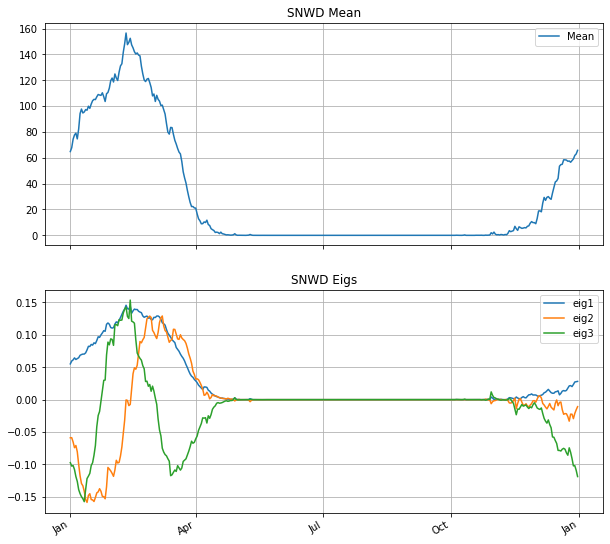

In [74]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
fig.savefig('r_figures/SNWD_mean_eigs')

## plot Percentage of variance explained

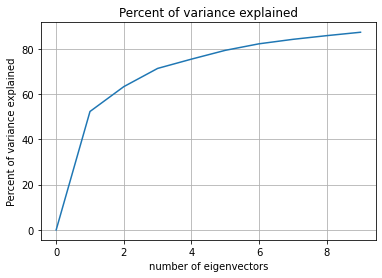

In [75]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Exploring the decomposition


### Intuitive analysis

In [76]:
#combine mean with Eigvecs and scale to similar range.
print(EigVec.shape)
_norm_Mean=Mean/max(Mean)*0.2
A=[_norm_Mean]+[EigVec[:,i] for i in range(EigVec.shape[1])]
Combined=np.stack(A).transpose()


(366, 3)


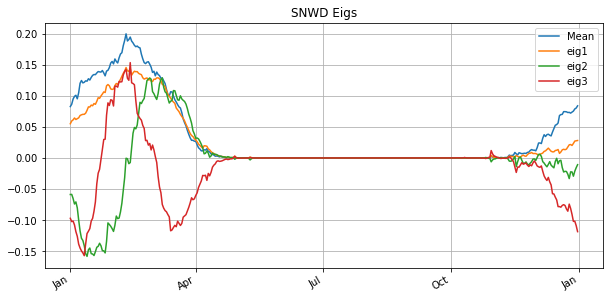

In [77]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(Combined,fig,axes,title=m+' Eigs',labels=['Mean']+['eig'+str(i+1) for i in range(k)])

* **Eig1** is very similar to the Mean --- Indicates heavy/light snow
* If **coef_1** is large: snow accumulation is higher.

* **Eig2** is positive january, negative march. Indicates early vs. late season
* If **coef_2** is high: snow season is early.

* **Eig3** is positive Feb, negative Jan, March -- Indicates a short or long season.
* If **Coef_3** is high: Season is short.

### Studying the effect of Coefficient 1

In [78]:
# Checking that res_2 is smaller than 0.1 and that rows are sorted based on coeff_2
df4=df2.filter(df2.res_1<0.1).sort(df2.coeff_1)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

241


In [79]:
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|-1003.96473...|122.1904414...|59.06081741...|0.045953264...|0.031749198...|0.028274253...|
|-1003.96473...|122.1904414...|59.06081741...|0.045953264...|0.031749198...|0.028274253...|
|-1003.96152...|121.3460782...|54.50636963...|0.044944415...|0.030897039...|0.027799273...|
|-1003.96152...|121.3460782...|54.50636963...|0.044944415...|0.030897039...|0.027799273...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



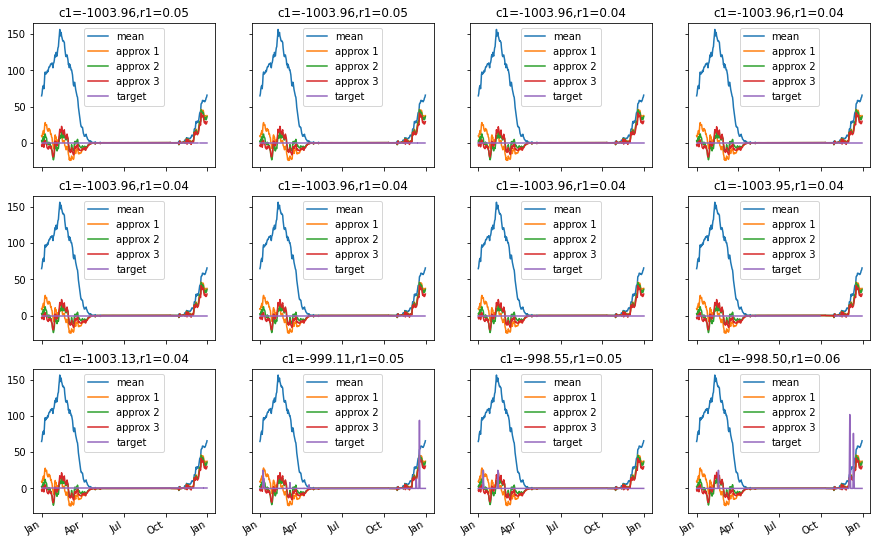

In [80]:
plot_recon_grid(all_rows[0:12],Mean,EigVec,header='c1=%3.2f,r1=%3.2f',params=('coeff_1','res_1'))

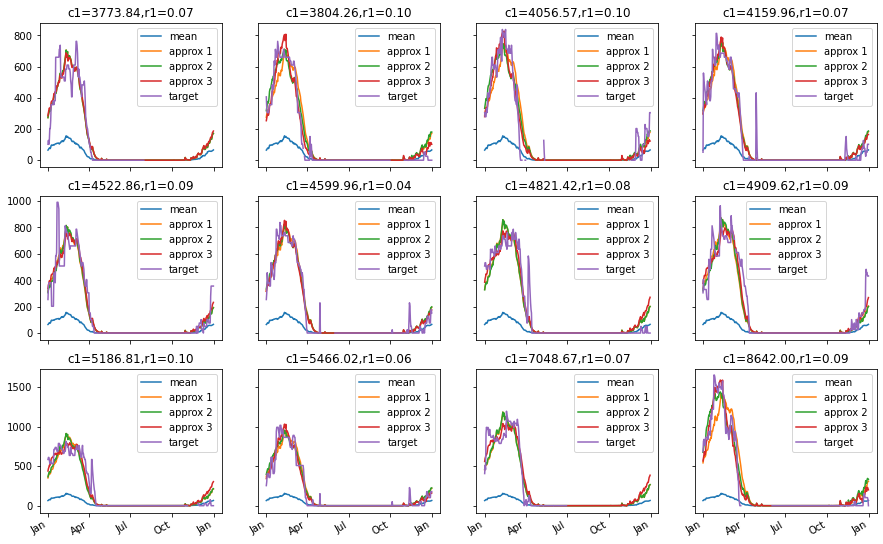

In [81]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c1=%3.2f,r1=%3.2f',params=('coeff_1','res_1'))

### Studying the effect of Coefficient 2

In [82]:
# Checking that res_2 is smaller than 0.1 and that rows are sorted based on coeff_2
df4=df2.filter(df2.res_2<0.1).sort(df2.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

354


In [83]:
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|4669.911393...|-2854.73871...|212.3300801442|0.337034996...|0.090424964...|0.089186776...|
|4414.914018...|-2629.86548...|354.4145977...|0.278723925...|0.048887022...|0.044874400...|
|3044.966024...|-2584.72806...|-86.5652329...|0.460027113...|0.070949028...|0.070512619...|
|8642.004188...|-2258.48545...|1122.222425...|0.091368165...|0.037353296...|0.025544162...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



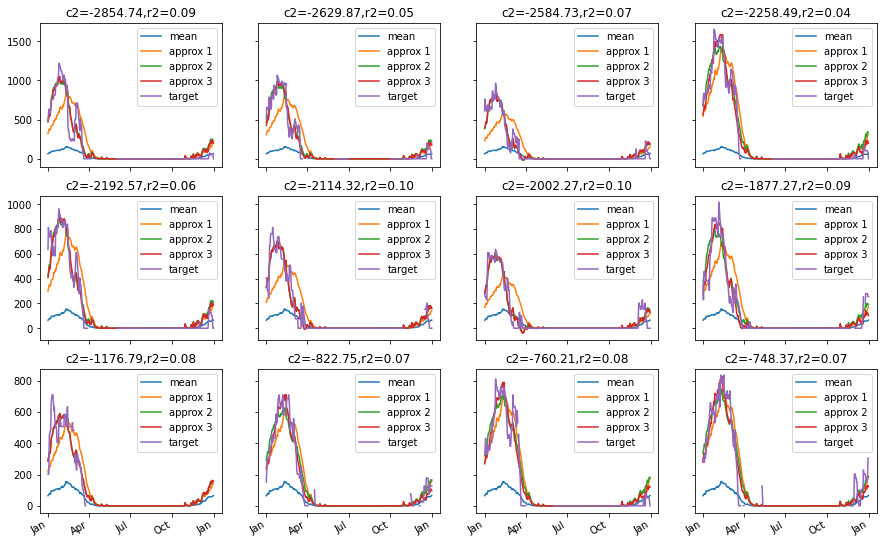

In [84]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

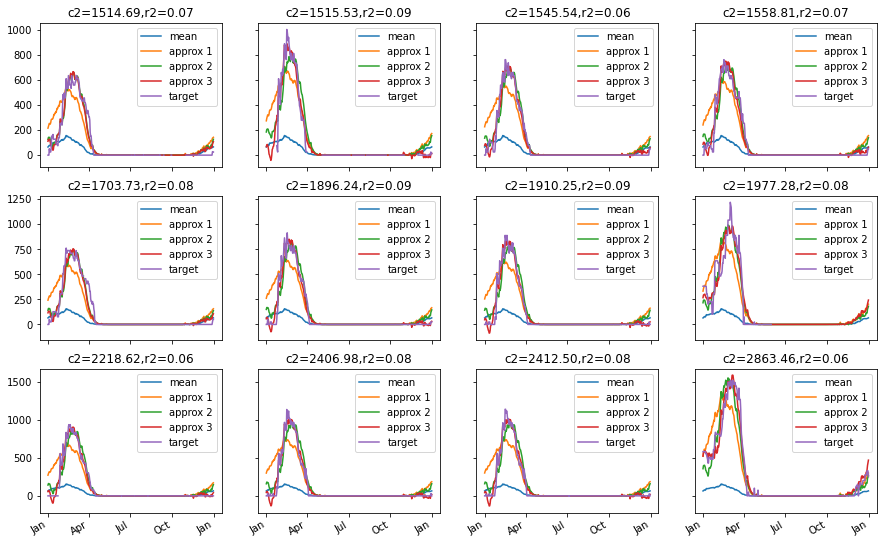

In [85]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

### Studying the effect of Coefficient 3

In [86]:
df4=df2.filter(df2.res_3<0.1).sort(df2.coeff_3)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

536


In [87]:
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|5102.441575...|-4033.76484...|-4123.28976...|0.592758773...|0.337794087...|0.063099711...|
|6874.374644...|1917.890071...|-2896.74815...|0.270694911...|0.214027348...|0.081676464...|
|8371.379532...|2863.455759...|-1692.09903...|0.156907317...|0.058389727...|0.023210721...|
|2181.687038...|1690.824113...|-1612.91537...|0.572272402...|0.315385046...|0.078044014...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



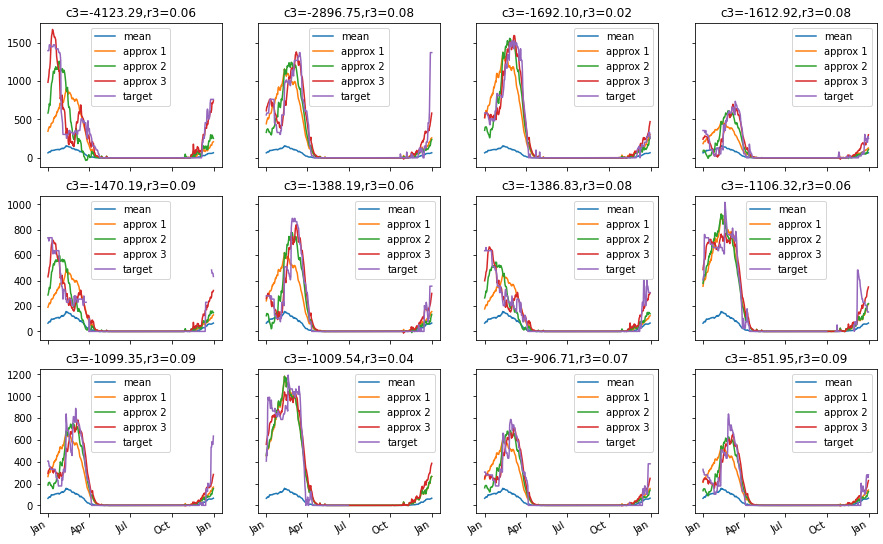

In [28]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c3=%3.2f,r3=%3.2f',params=('coeff_3','res_3'))

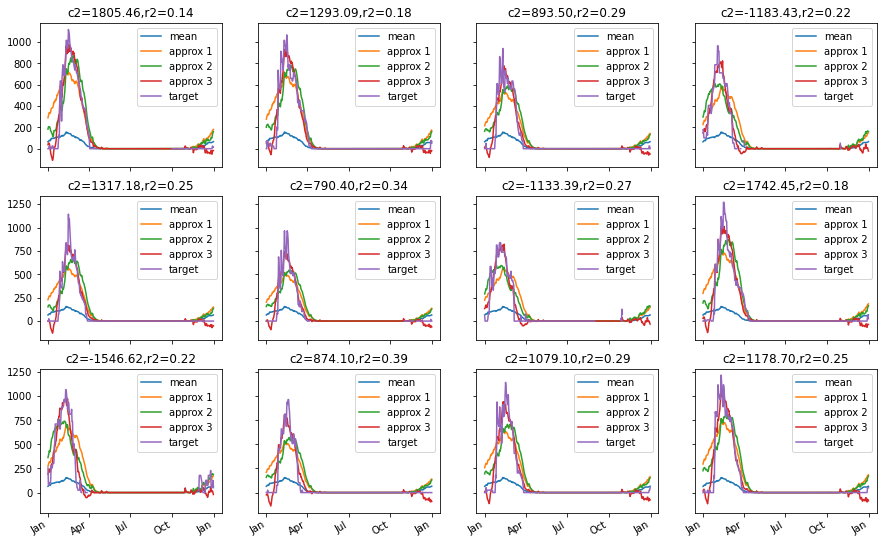

In [29]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)

### Best Fit

First, lets plot the SNWD sequences which are best approximated using the first three eigen-vectors.

In other words, the sequences for which the third residual is smallest.

We restrict ourselves to vectors where the first coefficient is positive: overall snow higher then mean.

We can think of these as **architypical** sequences.

In [38]:
df4=df2.filter(df2.coeff_1>0).sort(df2.res_3)
print(df4.count())
all_rows=df4.collect()
df4.select('coeff_1','coeff_2','coeff_3','res_3').show(n=4,truncate=14)

2562
+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_3|
+--------------+--------------+--------------+--------------+
|3771.383300...|2218.617435...|895.0109171...|0.022064114...|
|4279.864039...|2406.983713...|1190.486916...|0.022431796...|
|8371.379532...|2863.455759...|-1692.09903...|0.023210721...|
|4294.816596...|2412.495113...|1207.141748...|0.023395275...|
+--------------+--------------+--------------+--------------+
only showing top 4 rows



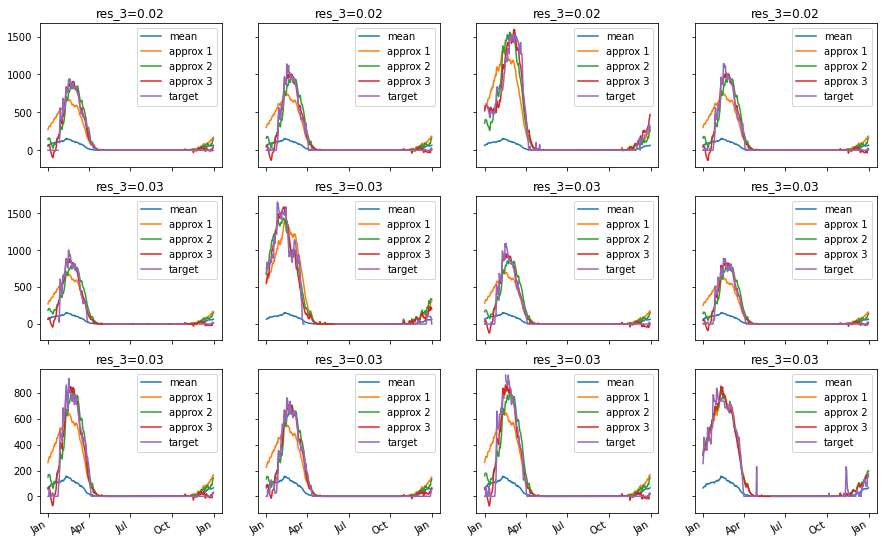

In [39]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## worst fit

Next, lets look at the sequence whose third residual is largest.

We can think of those as **outliers** or **noise**. These seuqnces do not fit our model. 

Have many of these outliers is a problem: we are either getting poor data, or else our model is inadequate.

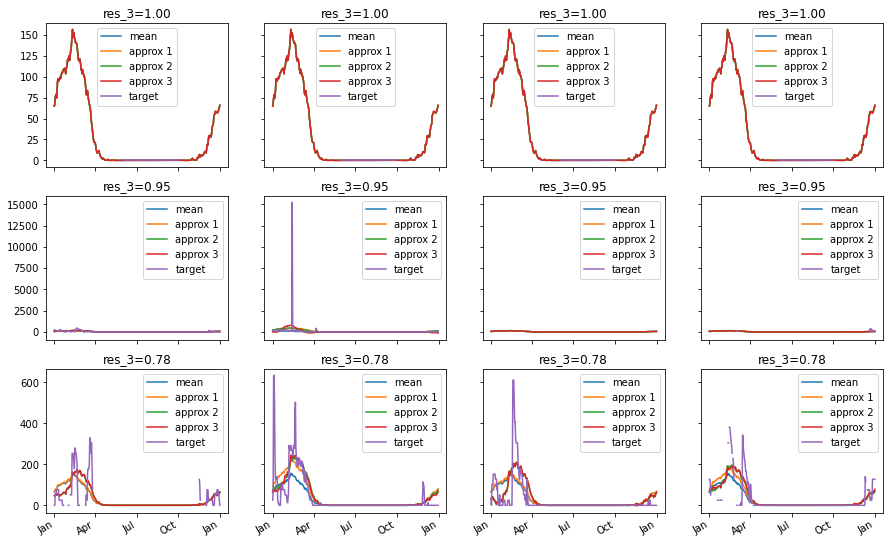

In [40]:
bad_rows=all_rows[-104:-100]+all_rows[-504:-500]+all_rows[-1004:-1000]
plot_recon_grid(bad_rows,Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

### Something to try
Clearly, the majority of the poor fits are a result of undefined entries in the data.  
Can you change the command to focus on years where most of the measurements are defined?

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [41]:
row=all_rows[0]
target=np.array(unpackArray(row.Values,np.int16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,EigVec)
total_var,residuals,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print('residual normalized norm  after mean:',res[0])
print('residual normalized norm  after mean + top eigs:',res[1:])

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.7202142687262119
residual normalized norm  after mean + top eigs: [0.28861615 0.06267424 0.02206411]


## Studying the distribution of the coefficients.

Coeff_1-3 capture most of the variance in the snow-depth distribution.

We can now look at how these coefficients vary from year to year.

In [48]:
pdf=df3.select(['Station','Year','coeff_1','coeff_2','coeff_3','res_1','res_2','res_3','res_mean','total_var']).toPandas()

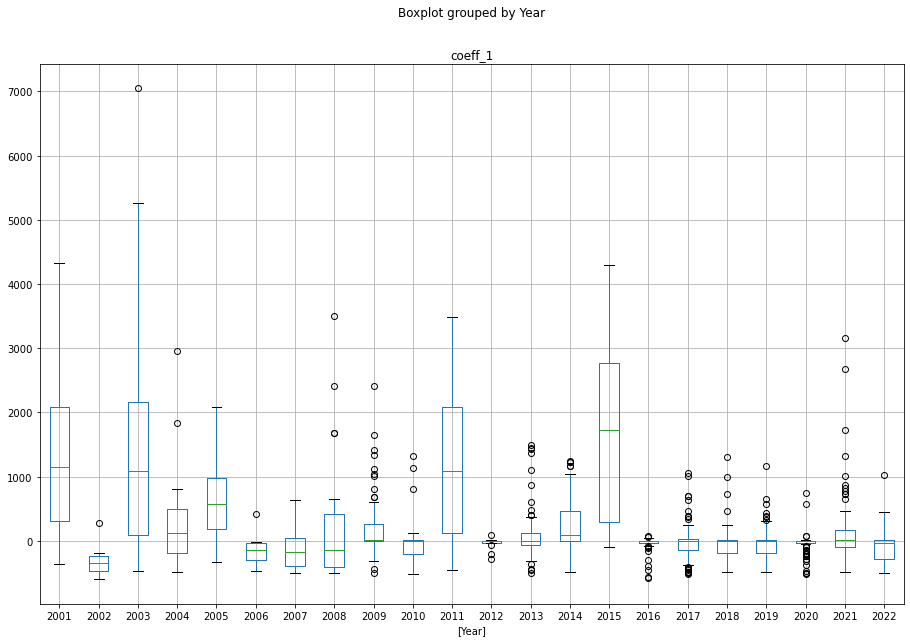

In [45]:
#coeff_1 corresponds to the overall amount of snow. 
# 2001,2011, 2015 were heavy snow years
pdf[['Year','coeff_1']][pdf['Year']>2000].boxplot(by='Year',figsize=[15,10]);

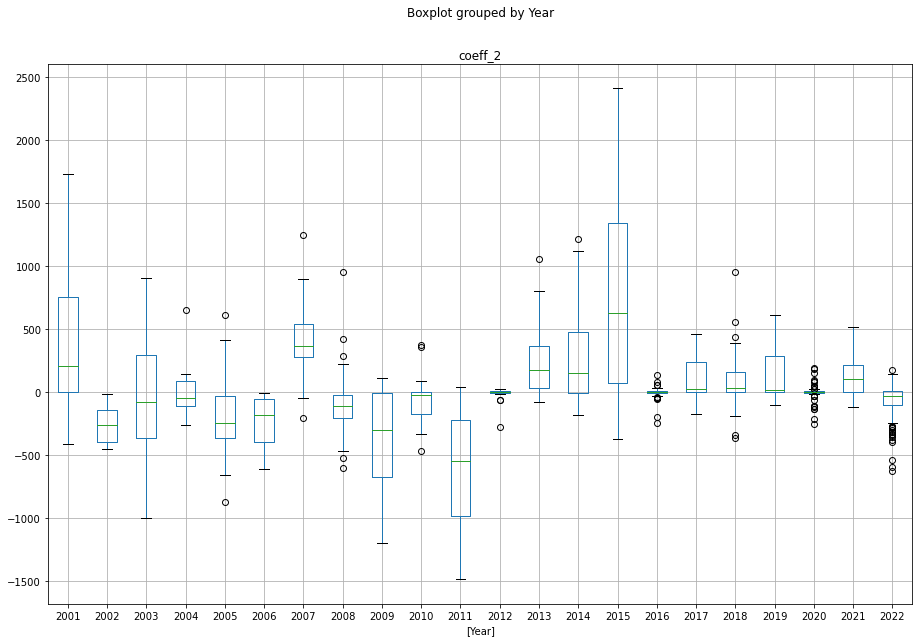

In [46]:
#coeff_2 corresponds to whether the snow was early or late
# 2011 was early 2015 was late
pdf[['Year','coeff_2']][pdf['Year']>2000].boxplot(by='Year',figsize=[15,10]);

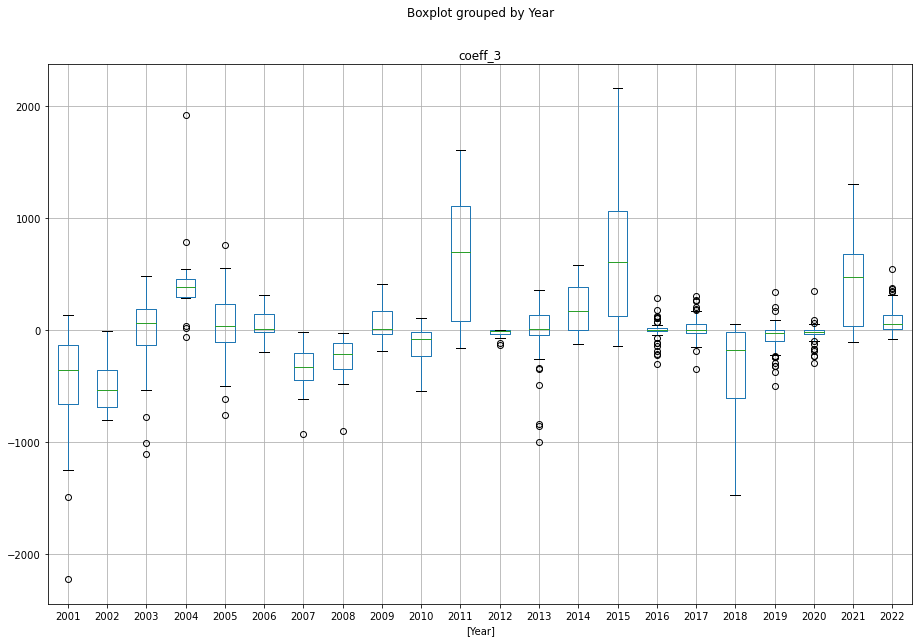

In [47]:
#coeff_2 corresponds to whether the snow season was short or long
# both 2011 and 2015 were long
pdf[['Year','coeff_3']][pdf['Year']>2000].boxplot(by='Year',figsize=[15,10]);

In [44]:
grpby=pdf.groupby('Year')['coeff_1']
ratio=grpby.mean()/grpby.std()
np.nanmax(ratio),np.nanmin(ratio)

(2.0936501815741706, -3.1381869748531686)

In [50]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat,power=2):
    rows=df4.select(feat).sort(feat).collect()
    vals=[r[feat]**power for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    axis.plot(vals,P,label=feat)

Populating the interactive namespace from numpy and matplotlib


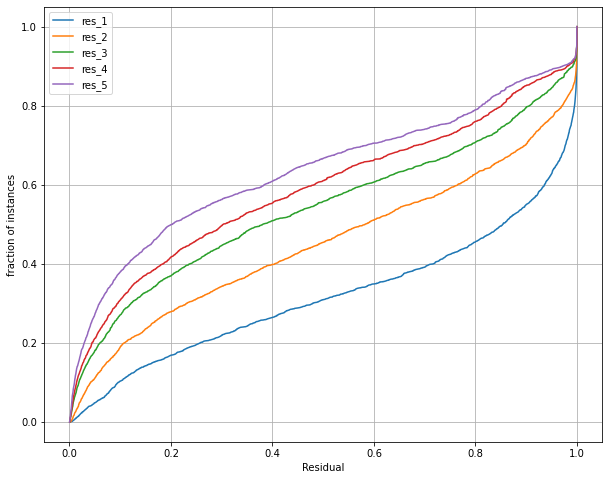

In [51]:
figure(figsize=(10,8))
axis=gca()

#plot_CDF('res_mean') # why does this not fit?
plot_CDF('res_1')
plot_CDF('res_2')
plot_CDF('res_3')
plot_CDF('res_4')
plot_CDF('res_5')
ylabel('fraction of instances')
xlabel('Residual')
grid()
legend();

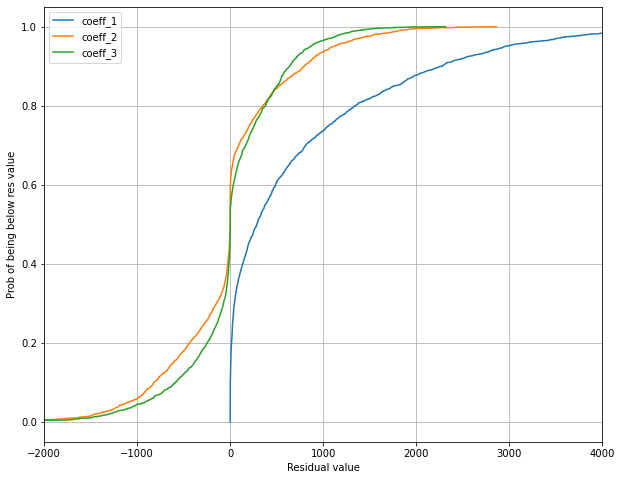

In [52]:
figure(figsize=(10,8))
axis=gca()

plot_CDF('coeff_1',power=1)
plot_CDF('coeff_2',power=1)
plot_CDF('coeff_3',power=1)

ylabel('Prob of being below res value')
xlabel('Residual value')
xlim([-2000,4000])
grid()
legend();